# Chick-fil-A

In [1]:
import requests
import pandas as pd
import geopandas as gpd

/Users/stiles/.local/share/virtualenvs/notebooks-sxqKeO4C/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

In [3]:
%load_ext lab_black

---

## ZIP Codes

In [4]:
zips = pd.read_csv(
    "https://grid-news-static-files.s3.us-east-2.amazonaws.com/data/usa-zips-wealth.csv"
)

In [5]:
zips_pop = zips.sort_values("totpop_cy", ascending=False).head(1500)

#### Get locations

In [6]:
cookies = {
    "__cf_bm": "fNCpunN8rEnZPNiObTAg1B46cqeO8IxjI9ebasrVx6s-1657977733-0-ASjZhBbj06P+ztVnJiMdiyXAqDfdj2fSG1CUFApZExMjUumrRKbmhz4cCZAaBUKqdKQGLVmzm9oNeehH30lfjqs=",
}

headers = {
    "authority": "locator.chick-fil-a.com.yext-cdn.com",
    "accept": "application/json",
    "accept-language": "en-US,en;q=0.9,es;q=0.8",
    "referer": "https://locator.chick-fil-a.com.yext-cdn.com/search?q=30354&per=10",
    "sec-ch-ua": '".Not/A)Brand";v="99", "Google Chrome";v="103", "Chromium";v="103"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36",
}

In [7]:
responses = []

for z in zips_pop["id"]:
    params = {
        "q": z,
        "per": "10",
    }

    response = requests.get(
        "https://locator.chick-fil-a.com.yext-cdn.com/search",
        params=params,
        cookies=cookies,
        headers=headers,
    )
    responses.append(response.json())

In [8]:
dicts = []

for r in responses:
    for p in r["response"]["entities"]:
        dicts.append(p["profile"])

In [9]:
src = pd.DataFrame(dicts)

In [10]:
src[
    [
        "city",
        "countryCode",
        "extraDescription",
        "line1",
        "line2",
        "line3",
        "postalCode",
        "region",
        "sublocality",
    ]
] = pd.json_normalize(src["address"])

In [11]:
src_slim = src[
    [
        "c_driveThru",
        "c_locationFormat",
        "c_locationName",
        "c_mall",
        "c_marketName",
        "c_openDate",
        "c_operatorName",
        "c_playground",
        "c_projectedOpenDate",
        "c_status",
        "geocodedCoordinate",
        "timezone",
        "websiteUrl",
        "city",
        "countryCode",
        "line1",
        "postalCode",
        "region",
    ]
].copy()

In [12]:
src_slim.columns = src_slim.columns.str.lower().str.replace("c_", "", regex=False)

In [13]:
src_slim[["open_day", "open_month", "open_year"]] = pd.json_normalize(
    src_slim["opendate"]
)

In [14]:
src_slim[["lat", "lon"]] = pd.json_normalize(src_slim["geocodedcoordinate"])

In [15]:
src_slim.drop(["geocodedcoordinate", "opendate"], axis=1, inplace=True)

In [16]:
src_slim.rename(
    columns={
        "operatorname": "operator",
        "websiteurl": "url",
        "projectedopendate": "other_date",
        "line1": "address",
        "postalcode": "zip",
        "mall": "in_mall",
        "locationformat": "format",
    },
    inplace=True,
)

In [17]:
df = src_slim[
    [
        "locationname",
        "marketname",
        "city",
        "countrycode",
        "address",
        "zip",
        "region",
        "lat",
        "lon",
        "operator",
        "status",
        "timezone",
        "url",
        "open_day",
        "open_month",
        "open_year",
        "other_date",
        "playground",
        "drivethru",
        "format",
        "in_mall",
    ]
].drop_duplicates()

----

In [18]:
df.head()

,locationname,marketname,city,countrycode,address,zip,region,lat,lon,operator,status,timezone,url,open_day,open_month,open_year,other_date,playground,drivethru,format,in_mall
0,Morton Ranch,"Houston, TX",Katy,US,2826 W Grand Pkwy N,77449,TX,29.814042,-95.772170,Amanda Baca,OPEN,America/Chicago,https://www.chick-fil-a.com/mortonranch,30.0,11.0,2017.0,2017-11-30,interior,True,Stand Alone,False
1,Mason Road,"Houston, TX",Katy,US,369 S Mason Rd,77450,TX,29.780570,-95.751140,Rusty Wylie,OPEN,America/Chicago,https://www.chick-fil-a.com/masonroad,14.0,9.0,1995.0,2014-10-02,interior,True,Stand Alone,False
2,Katy Green,"Houston, TX",Houston,US,19303 Katy Fwy,77094,TX,29.784326,-95.706519,Rusty Wylie,OPEN,America/Chicago,https://www.chick-fil-a.com/katygreen,11.0,6.0,2015.0,2015-06-11,interior,True,Stand Alone,False
3,Katy Mills,"Houston, TX",Katy,US,25601 Nelson Way,77494,TX,29.774121,-95.819225,Cynthia Cavin,OPEN,America/Chicago,https://www.chick-fil-a.com/katymills,26.0,4.0,2012.0,2011-12-08,interior,True,Stand Alone,False
4,Cinco Ranch,"Houston, TX",Katy,US,23860 Westheimer Pkwy,77494,TX,29.735510,-95.778000,Rusty Wylie,OPEN,America/Chicago,https://www.chick-fil-a.com/cincoranch,2.0,6.0,2005.0,2005-06-02,interior,True,Stand Alone,False


#### How many?

In [19]:
len(df)

2360

In [20]:
formats = ["Stand Alone", "In-Line", "Food Court"]

In [21]:
df_open = df[(df["status"] == "OPEN") & (df["region"] != "AK") & (df["lat"] > 0)].copy()
df_open_clean = df[df["format"].isin(formats)]

---

## Geodataframe

In [23]:
gdf = gpd.GeoDataFrame(
    df_open_clean, geometry=gpd.points_from_xy(df_open_clean.lon, df_open_clean.lat)
)

<AxesSubplot:>

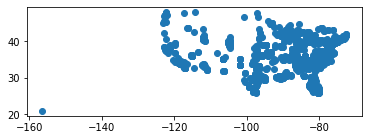

In [24]:
gdf.plot()

---

In [27]:
df_open_clean.to_csv("data/processed/locations.csv", index=False)

In [26]:
gdf.to_file("data/processed/locations_geo.geojson", driver="GeoJSON")